In [1]:
import numpy as np
from pylab import meshgrid
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
with open('proportions.npy', 'rb') as f:
    a = np.load(f, allow_pickle=True)
    

In [40]:
import argparse
import os
import pickle

import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.datasets import cifar10


def generate_datasets(iid=False, alpha=1.0, num_clients=100):
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_train = np.transpose(x_train, (0, 3, 1, 2))
    x_test = x_test.astype('float32') / 255.0
    x_test = np.transpose(x_test, (0, 3, 1, 2))
    
    np.random.seed(1234)
    x_train, y_train = shuffle(x_train, y_train)
    x_test, y_test = shuffle(x_test, y_test)
    
    train_user_ids = [str(id) for id in range(num_clients)]
    x_test_splits = np.split(x_test, num_clients)
    y_test_splits = np.split(y_test, num_clients)
    
    if iid:
        x_train_splits = np.split(x_train, num_clients)
        y_train_splits = np.split(y_train, num_clients)
    else:
        print('generating non-iid data')
        min_size = 0
        K = 10
        N = y_train.shape[0]
        client_dataidx_map = {}
        
        while min_size < 10:
            proportion_list = []
            idx_batch = [[] for _ in range(num_clients)]
            # for each class in the dataset
            for k in range(K):
                idx_k = np.where(y_train == k)[0]
                np.random.shuffle(idx_k)
                proportions = np.random.dirichlet(np.repeat(alpha, num_clients))

                ## Balance
                proportions = np.array([p * (len(idx_j) < N / num_clients) for p, idx_j in zip(proportions, idx_batch)])
                proportions = proportions / proportions.sum()
                proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
                print(proportions)
                idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]
                min_size = min([len(idx_j) for idx_j in idx_batch])
                proportion_list.append(proportions)
        x_train_splits, y_train_splits = [], []
        for j in range(num_clients):
            np.random.shuffle(idx_batch[j])
            client_dataidx_map[j] = idx_batch[j]
            x_train_splits.append(x_train[idx_batch[j], :])
            y_train_splits.append(y_train[idx_batch[j], :])
    
    test_dataset = {}
    train_dataset = {}
    for id, index in zip(train_user_ids, range(num_clients)):
        
        train_dataset[id] = {'x': x_train_splits[index], 'y': y_train_splits[index].flatten()}
        test_dataset[id] = {'x': x_test_splits[index], 'y': y_test_splits[index].flatten()}
        
    return train_dataset

In [60]:
train_set = generate_datasets(False, alpha=0.1, num_clients=20)
data = np.array([[len(np.where(train_set[idx]['y']  == k)[0]) for k in range(10) ] for idx in train_set.keys()])
scale = max(data.sum(axis=1)) / data.sum(axis=1)
scale = scale[:, None]
data = (data * scale)

generating non-iid data
[   0    0  264  264 1237 1237 1240 2726 4477 4477 4477 4477 4979 4979
 4979 4994 4994 4994 4994]
[  35   35  121  621  621  621  621  621  701 1373 1373 2817 4609 4620
 4620 4620 4997 4997 4997]
[   9  328  632  808  808  808  808  842  842  861 1549 1549 1550 2319
 2644 2644 3407 3409 3544]
[   1    1 1035 1035 1039 1039 1051 1053 4875 4888 4888 4889 4890 4890
 4890 4892 4892 4892 5000]
[   0    0    7    8   65   65   80  197  197 4307 4307 4307 4714 4714
 4715 4723 4723 4745 4774]
[   0  232  232  232  681  683  683  683  683  683  684  684  684 2582
 2582 2582 3652 3653 4999]
[1765 1767 3020 3026 3262 3262 3262 3714 3714 3714 3714 4107 4107 4107
 4107 4378 4998 4999 4999]
[   0    0    0    0  118  118 2303 4176 4176 4176 4197 4287 4287 4287
 4287 4287 4287 4314 4351]
[   0    0    0   16   16 4999 4999 4999 4999 4999 4999 4999 4999 4999
 4999 4999 4999 4999 4999]
[   2 1804 1804 1804 1804 1804 4360 4360 4360 4360 4360 4363 4363 4363
 4561 4561 4561 4908 49

In [61]:

N = 10
r0 = 0.6
x = range(1, 21)
y = range(0, 10)
X, Y = meshgrid(x, y)
size = data.T
c = size

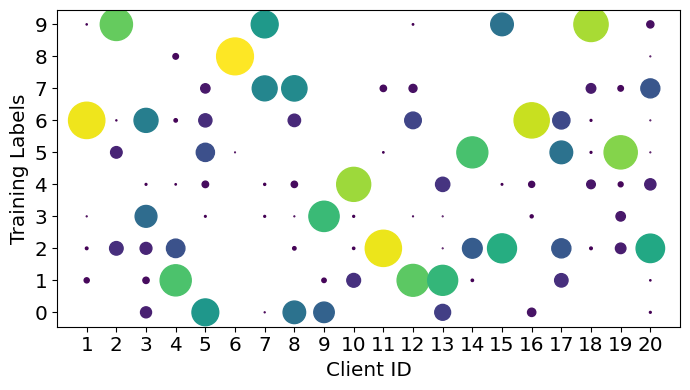

In [63]:
fig, ax1 = plt.subplots()#figsize=(100, 4))

ax1.set_ylabel("Training Labels")
ax1.set_xlabel("Client ID")
ax1.set_xlim(0,21)
ax1.scatter(X,Y,s=700 * size / size.max(), marker='o', c=c)
ax1.set_xticks(x)
ax1.set_yticks(y)
fig.set_size_inches(7,4)
fig.set_dpi(100)
plt.tight_layout()
fig.savefig("../../../bubble.pdf", bbox_inches='tight')
plt.show()